# Litteraturbanken Author 
version 1.21 -  added link hub  

* this [notebook](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb)
  * [video Swedish](https://youtu.be/ttcboFaBi5U)
 
* [Wikidata:WikiProject_Sweden/The_Swedish_Literature_bank](https://www.wikidata.org/wiki/Wikidata:WikiProject_Sweden/The_Swedish_Literature_bank)

* [video exempel hur en post skapas](https://youtu.be/Grmp8_DZq8o)

#### Other sources we sync
* check for [pictures in SPA for WD objecst connected to Litteraturbanken](https://github.com/salgo60/spa2Commons/blob/main/Notebook/Litteraturbanken%20SPA.ipynb)
  * **Status** _same as_ [WD - LIBRIS XL - Litterturbanken](https://github.com/salgo60/spa2Commons/blob/main/Notebook/Litteraturbanken%20-%20samma%20som.ipynb)

* [Arken](https://github.com/salgo60/open-data-examples/blob/master/Arken.ipynb) 
  * WD [Property:P8899](https://www.wikidata.org/wiki/Property:P8899) 
* [Kulturpersoner Uppsalakyrkogård](https://github.com/salgo60/open-data-examples/blob/master/Check%20WD%20kulturpersoner%20uppsalakyrkogardar.ipynb)
* [Litteraturbanken](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb) 
  * WD property [P5101](https://www.wikidata.org/wiki/Property_talk:P5101) [P5123](https://www.wikidata.org/wiki/Property_talk:P5123)
  *  [Litteraturkartan](https://litteraturbanken.se/litteraturkartan)
     * WD property [P9213](https://www.wikidata.org/wiki/Property:P9213)
* [Nobelprize.org](https://github.com/salgo60/open-data-examples/blob/master/Nobel%20API.ipynb)
  * WD [property 8024](https://www.wikidata.org/wiki/Property:P8024)
* [SBL](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb) 
  * WD [property 3217](https://www.wikidata.org/wiki/Property:P3217) 
* [SKBL](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)
  * WD [property 4963](https://www.wikidata.org/wiki/Property:P4963)
* [Svenska Akademien](https://github.com/salgo60/open-data-examples/blob/master/Svenska%20Akademien.ipynb) 
  * WD [property 5325](https://www.wikidata.org/wiki/Property:P5325) 

#### Misc
* [T238932 API Litteraturbanken]([https://phabricator.wikimedia.org/T238932)
  * good API documention has not been found
  * GITHUB [spraakbanken/littb-frontend](https://github.com/spraakbanken/littb-frontend)
      * Question 
        * ~~how to see [JSON for a record 23](https://github.com/spraakbanken/littb-frontend/issues/23)~~
        * ~~[feedback data 24](https://github.com/spraakbanken/littb-frontend/issues/24)~~  
          * question if they will have [Persistent Litteraturbanken place id](https://github.com/spraakbanken/littb-frontend/issues/24#issuecomment-711140342)
  * API [get_authors](https://litteraturbanken.se/api/get_authors)
  * [url_list](https://litteraturbanken.se/api/url_list)
  * [API List all 0-10 include](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10&include=authors,forfattare,lbworkid,titlepath,title,librisid,mediatype,main_author.author_id)
    * [List all 0-10](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10)
  * Wikidata 
    * property [P5101](https://www.wikidata.org/wiki/Property:P5101)
    * [other properties](https://w.wiki/eck) on the same object as Litterturbanken Author
* [Wikidata properties also available](https://w.wiki/eck) when we have P5101

**The objective** 
1. Find all Litteraturbanken Author objects that has Show True
1. Try to match Wikidata or create a new object for as many authors in Litteraturbanken as possible
  1. lesson learned not all authors are identified by Litteraturbanken --> maybe we should not create everyone in Wikidata or is Wikidata a good place to find relations e.g. [Louise Müller](https://www.wikidata.org/wiki/Q100566908?uselang=sv) same as
     1. Alvin [alvin-person:6474](http://www.alvin-portal.org/alvin/view.jsf?pid=alvin-person:6474)
     1. wife Riksarkivet SBL _J Daniel A Müller_ [id=8596](https://sok.riksarkivet.se/sbl/Presentation.aspx?id=8596) 
     1. VIAF [18128821](https://viaf.org/viaf/18128821/)
        1. LIBRISXL [qn259h685g929bf](https://libris.kb.se/katalogisering/qn259h685g929bf) / [JSON](https://libris.kb.se/qn259h685g929bf/data.jsonld)
1. If Litteraturbanken has identified an author with LIBRIS id and we dont find it in Wikidata we create it

**Lesson learned**
1. we need to filter using Show True
  1-1. looks like we need better filter e.g. "[CanthM](https://litteraturbanken.se/f%C3%B6rfattare/CanthM)" has false but has text see [tweet question](https://twitter.com/salgo60/status/1313834219794296834?s=20)
2. in Wikidata we get entries from my earlier load but also Mix-and-Match [katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) --> we have also got the form "authorid_norm" that I feel we should not use --> some cleaning



## Issues
### 1) Filter out authors with no books 
* BergenstråhleJ miss books 
* BjorklundJA miss books

**solution** Filter on field Show

LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True]   

### 2) copyright on metadata?
Should be ok see [JSON for a record 23 comment 707542448](https://github.com/spraakbanken/littb-frontend/issues/23#issuecomment-707542448)

### 3) Persistent indentifiers for Litteraturbanken
Example what Litteraturbanken plans to do see [Facebook](https://www.facebook.com/Litteraturbanken.se/videos/261954861599359)
* suggestion that they use Public identifiers see [question https24#issuecomment-711140342](https://github.com/spraakbanken/littb-frontend/issues/24#issuecomment-711140342)

In [1]:
import ipyplot
listOfImageNames = ['LitteraturbankenWD.png']

ipyplot.plot_images(listOfImageNames,img_width=700)

In [2]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2023-01-02 02:14:42.645216


In [3]:
import urllib3, json
import pandas as pd 
http = urllib3.PoolManager() 
pd.set_option("display.max.columns", None) 
 
url = "https://litteraturbanken.se/api/get_authors"
r = http.request('GET', url)
data = json.loads(r.data)
df = pd.DataFrame(data["data"])

In [4]:
#df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4712 entries, 0 to 4711
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   authorid              4712 non-null   object 
 1   authorid_norm         4712 non-null   object 
 2   birth                 4712 non-null   object 
 3   db_checksum           4712 non-null   object 
 4   db_timestamp          4712 non-null   int64  
 5   death                 3971 non-null   object 
 6   doc_type              4712 non-null   object 
 7   full_name             4712 non-null   object 
 8   gender                4712 non-null   object 
 9   imported              4072 non-null   object 
 10  intro                 746 non-null    object 
 11  librisid              2689 non-null   object 
 12  name_for_index        4712 non-null   object 
 13  pictureinfo           224 non-null    object 
 14  searchable            4712 non-null   bool   
 15  show                 

In [5]:
#df.info() 
df[df['authorid_norm'].str.contains("BirchPfeifferC")]

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,intro_text,popularity,dramawebben,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
481,BirchPfeifferC,BirchPfeifferC,"{'date': '1800', 'plain': '1868'}",a4ba99138da2a29c78a5f39c12fe7649,1669642198310,{'plain': '1800'},author,Charlotte Birch-Pfeiffer,female,2018-10-25,None,NaN,"Birch-Pfeiffer, Charlotte",None,False,False,Birch-Pfeiffer,2019-05-14,NaN,NaN,NaN,NaN,"{'intro': None, 'intro_author': 'LagercrantzMV...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# create a smaller dataset from this
listLittWD = []
for index,row in df.iterrows():
    new_item = dict()
    new_item['authorid'] = row['authorid']
    new_item['authorid_norm'] = row['authorid_norm']
    new_item['show'] = row['show']
    new_item['updated'] = row['updated']
    new_item['full_name'] = row['full_name']
    new_item['imported'] = row['imported']
    new_item['librisid'] = row['librisid']   
    wd = row['wikidata']
    try:            
        new_item['wd_hos_Litteraturbanken'] = wd['wikidata_id']
    except:
        pass
    listLittWD.append(new_item)
LitteraturbankenTot = pd.DataFrame(listLittWD,
                  columns=['full_name','authorid','wd_hos_Litteraturbanken','authorid_norm','show','updated','imported','librisid'])
#LitteraturbankenTot["updated"] = LitteraturbankenTot["updated"].astype("datetime64")
#LitteraturbankenTot["imported"] = LitteraturbankenTot["imported"].astype("datetime64")

LitteraturbankenTot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4712 entries, 0 to 4711
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   full_name                4712 non-null   object
 1   authorid                 4712 non-null   object
 2   wd_hos_Litteraturbanken  2881 non-null   object
 3   authorid_norm            4712 non-null   object
 4   show                     4712 non-null   bool  
 5   updated                  4072 non-null   object
 6   imported                 4072 non-null   object
 7   librisid                 2689 non-null   object
dtypes: bool(1), object(7)
memory usage: 262.4+ KB


In [7]:
#LitteraturbankenTot["authorid"].value_counts()

In [8]:
# flag I guess we should use
LitteraturbankenTot["show"].value_counts()

True     3674
False    1038
Name: show, dtype: int64

In [9]:
LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True] 

LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3674 entries, 1 to 4711
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   full_name                3674 non-null   object
 1   authorid                 3674 non-null   object
 2   wd_hos_Litteraturbanken  2872 non-null   object
 3   authorid_norm            3674 non-null   object
 4   show                     3674 non-null   bool  
 5   updated                  3244 non-null   object
 6   imported                 3244 non-null   object
 7   librisid                 2173 non-null   object
dtypes: bool(1), object(7)
memory usage: 233.2+ KB


In [10]:
#LitteraturbankenTotShow

### Latest updated at Litteraturbanken

In [11]:
# latest updated 
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['updated'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:70]

,full_name,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,Robert Litzén,LitzénR,Q111688807,LitzenR,True,9999-01-01,9999-01-01,mkz25fq52zcxd7v
1,Sven Pettersson,PetterssonS,NaN,PetterssonS,True,9999-01-01,9999-01-01,NaN
2,Daniel Möller,MöllerD,NaN,MollerD,True,2022-11-28,2018-01-18,20dgkckl01lmd80
3,Leontine S. E. Schwabitz,SchwabitzLSE,NaN,SchwabitzLSE,True,2022-11-28,2022-11-28,NaN
4,Anders August Hammarström,HammarströmAA,NaN,HammarstromAA,True,2022-11-28,2022-11-28,wt79c2xf2522h0w
...,...,...,...,...,...,...,...,...
65,Karl August Nicander,NicanderKA,Q267959,NicanderKA,True,2022-11-28,2011-02-16,53hkmr7p1smgldg
66,Wilhelm von Braun,BraunWvon,Q5585454,BraunWvon,True,2022-11-28,2011-02-10,42gjltcn2txb585
67,Jonas Carlquist,CarlquistJ,Q100153462,CarlquistJ,True,2022-11-28,2017-01-02,zw9djbxh17ffxtc
68,Janken Myrdal,MyrdalJ,NaN,MyrdalJ,True,2022-11-28,2022-11-28,97mpqc8t46lmgbb


### Latest imported at Litteraturbanken

In [12]:
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['imported'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:410]

,full_name,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,Robert Litzén,LitzénR,Q111688807,LitzenR,True,9999-01-01,9999-01-01,mkz25fq52zcxd7v
1,Sven Pettersson,PetterssonS,NaN,PetterssonS,True,9999-01-01,9999-01-01,NaN
2,Paul Nylén,NylénP,NaN,NylenP,True,2022-11-28,2022-11-28,nl025rd65c2z90n
3,Alessandro Palumbo,PalumboA,NaN,PalumboA,True,2022-11-28,2022-11-28,53hlvwsp1h3t3jc
4,Karin Lagergren,LagergrenK,NaN,LagergrenK,True,2022-11-28,2022-11-28,NaN
...,...,...,...,...,...,...,...,...
405,Viktor Bruzelius,BruzeliusV,NaN,BruzeliusV,True,2021-11-29,2021-11-29,NaN
406,Johan Martin Omberg,OmbergJM,Q109869339,OmbergJM,True,2021-11-29,2021-11-29,sq469tkb0jq927m
407,Erik Zillén,ZillénE,Q109906340,ZillenE,True,2021-11-29,2021-11-29,8jx0rt2462cb5tpr
408,Carl Fredrik von Saltza,SaltzaCF,Q5040163,SaltzaCF,True,2021-11-29,2021-11-29,q1jw6splnjc0n9f2


## Wikidata
query WIkidata for all records with an Littearturbanken Author id

In [13]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# https://w.wiki/ffr
query = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?authorid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P5101 ?authorid
} order by ?authorid"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']
    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDLittbanktot = get_sparql_dataframe(endpoint_url, query)


In [14]:
WDLittbanktot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966 entries, 0 to 2965
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WikidataID  2966 non-null   object
 1   authorid    2966 non-null   object
dtypes: object(2)
memory usage: 46.5+ KB


Duplicates in WD https://w.wiki/eM2
We try to have one if two then set one to preferred rang

In [15]:
WDLittbanktot[WDLittbanktot.duplicated(subset=['WikidataID'])].count()

WikidataID    5
authorid      5
dtype: int64

Check if we get LilljegrenJ from Wikidata as Wikidata has a big delay right now 2020-10-08 see 
[Grafana Lag](https://grafana.wikimedia.org/d/000000489/wikidata-query-service?orgId=1&refresh=1m)


In [16]:
WDLittbanktot[WDLittbanktot['authorid'].str.contains("WahlinKr")]

,WikidataID,authorid


## Merge Litteraturbanken dataset with Wikidata
Finds if we have a mismatch

In [17]:
#merge 
dfmerge = pd.merge(WDLittbanktot, LitteraturbankenTotShow,how='outer', on='authorid',indicator=True)
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
#dfmerge["_merge"].value_counts()   
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','Litterturbanken_only')
dfmerge.rename(columns={"_merge": "WD_Litteraturbanken"},inplace = True)    
dfmerge = dfmerge.sort_values(by=['updated'], ascending=[False])

dfmerge[0:30]  

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
2966,NaN,PetterssonS,Sven Pettersson,NaN,PetterssonS,True,9999-01-01,9999-01-01,NaN,Litterturbanken_only
1662,Q111688807,LitzénR,Robert Litzén,Q111688807,LitzenR,True,9999-01-01,9999-01-01,mkz25fq52zcxd7v,both
1879,Q5999630,MyrdalJ,Janken Myrdal,NaN,MyrdalJ,True,2022-11-28,2022-11-28,97mpqc8t46lmgbb,both
1768,Q762949,MalmströmA,August Malmström,Q762949,MalmstromA,True,2022-11-28,2018-10-25,rp369cp95m1xsw6,both
2620,Q6205468,TegnérEyngre,Esaias Tegnér den yngre,Q6205468,TegnerEyngre,True,2022-11-28,2018-10-25,mkz12p6536tnr4d,both
1751,Q42712348,LönnlövS,Sebastian Lönnlöv,NaN,LonnlovS,True,2022-11-28,2022-11-28,khw060x32ssmx36,both
2952,Q4991106,ÖdmannJM,Jenny Maria Ödmann,Q4991106,OdmannJM,True,2022-11-28,2008-12-28,vs68573d1gs3jvn,both
133,Q57351,ArndtEM,Ernst Moritz Arndt,Q57351,ArndtEM,True,2022-11-28,2018-05-09,khw03pr31gn509c,both
1763,Q4965144,MallingM,Mathilda Malling,Q4965144,MallingM,True,2022-11-28,2013-01-10,nl025gt63vtjjxk,both
2593,Q1499968,SätherbergH,Herman Sätherberg,Q1499968,SatherbergH,True,2022-11-28,2008-12-28,ljx02k941vcpbnc,both


In [18]:
# WikidataID is Wikidata object
# wd_hos_Litteraturbanken is the Wikidata object at Litteraturbanken 
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3697 entries, 2966 to 3696
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   WikidataID               2966 non-null   object
 1   authorid                 3697 non-null   object
 2   full_name                3674 non-null   object
 3   wd_hos_Litteraturbanken  2872 non-null   object
 4   authorid_norm            3674 non-null   object
 5   show                     3674 non-null   object
 6   updated                  3244 non-null   object
 7   imported                 3244 non-null   object
 8   librisid                 2173 non-null   object
 9   WD_Litteraturbanken      3697 non-null   object
dtypes: object(10)
memory usage: 317.7+ KB


In [19]:
dfmerge["show"].value_counts()

True    3674
Name: show, dtype: int64

### Check diff Wikidata <-> Litteraturbanken 

1. **WD_only** --> är oftast att Wikidata har den normerade egenskapen och skall bytas

2. **Litterturbanken_only** skall skapas/matchas i Wikidata särskild om LIBRIS id finns

  2-1. se [mix-and-match katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) för verktyg att koppla ihop
 

In [20]:
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    2943
Litterturbanken_only     731
WD_only                   23
Name: WD_Litteraturbanken, dtype: int64

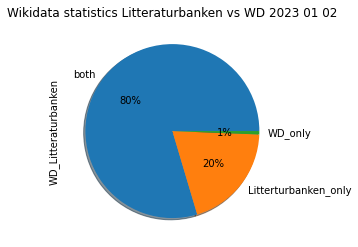

In [21]:
%matplotlib inline 
import matplotlib.pyplot as plt   
mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [22]:
mergeCheckNumber

both                    2943
Litterturbanken_only     731
WD_only                   23
Name: WD_Litteraturbanken, dtype: int64

### Check diff Wikidata <-> Litteraturbanken were we have LIBRISid

In [23]:
#mergewithLibris

In [24]:
mergewithLibris = dfmerge[dfmerge["librisid"].notnull()].copy() 
#plotmerge = mergewithLibris.plot.pie( \
#                   autopct='%1.0f%%', \
#                   shadow=True, startangle=0, \
#                   title = "Wikidata statistics Litteraturbanken with LIBRIS " + start_time.strftime('%Y %m %d'))
#plotmerge.plot( kind = 'bar',subplots=True) 
#plt.title("LIBRIS ")
#plt.savefig('LitteraturbankenWDLibris.png')
#plt.show()


In [25]:
mergewithLibris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 1662 to 103
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   WikidataID               2170 non-null   object
 1   authorid                 2173 non-null   object
 2   full_name                2173 non-null   object
 3   wd_hos_Litteraturbanken  2089 non-null   object
 4   authorid_norm            2173 non-null   object
 5   show                     2173 non-null   object
 6   updated                  2173 non-null   object
 7   imported                 2173 non-null   object
 8   librisid                 2173 non-null   object
 9   WD_Litteraturbanken      2173 non-null   object
dtypes: object(10)
memory usage: 186.7+ KB


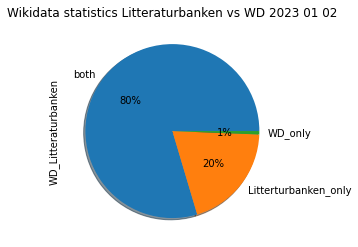

In [26]:


mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [27]:
mergeCheckNumber

both                    2943
Litterturbanken_only     731
WD_only                   23
Name: WD_Litteraturbanken, dtype: int64

In [28]:
pd.set_option("display.max.rows", None) 
 
wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"]
# could be items with Show false at Litteraturbanken 
wdonly.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 204 to 2800
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   WikidataID               23 non-null     object
 1   authorid                 23 non-null     object
 2   full_name                0 non-null      object
 3   wd_hos_Litteraturbanken  0 non-null      object
 4   authorid_norm            0 non-null      object
 5   show                     0 non-null      object
 6   updated                  0 non-null      object
 7   imported                 0 non-null      object
 8   librisid                 0 non-null      object
 9   WD_Litteraturbanken      23 non-null     object
dtypes: object(10)
memory usage: 2.0+ KB


In [29]:
LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3674 entries, 0 to 3673
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   full_name                3674 non-null   object
 1   authorid                 3674 non-null   object
 2   wd_hos_Litteraturbanken  2872 non-null   object
 3   authorid_norm            3674 non-null   object
 4   show                     3674 non-null   bool  
 5   updated                  3244 non-null   object
 6   imported                 3244 non-null   object
 7   librisid                 2173 non-null   object
dtypes: bool(1), object(7)
memory usage: 204.6+ KB


In [30]:
wdonly_norm = pd.merge(wdonly, LitteraturbankenTotShow,how='outer', left_on='authorid', right_on='authorid_norm',indicator=True)
wdonly_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3682 entries, 0 to 3681
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   WikidataID                 23 non-null     object  
 1   authorid_x                 23 non-null     object  
 2   full_name_x                0 non-null      object  
 3   wd_hos_Litteraturbanken_x  0 non-null      object  
 4   authorid_norm_x            0 non-null      object  
 5   show_x                     0 non-null      object  
 6   updated_x                  0 non-null      object  
 7   imported_x                 0 non-null      object  
 8   librisid_x                 0 non-null      object  
 9   WD_Litteraturbanken        23 non-null     object  
 10  full_name_y                3674 non-null   object  
 11  authorid_y                 3674 non-null   object  
 12  wd_hos_Litteraturbanken_y  2872 non-null   object  
 13  authorid_norm_y            3674 n

In [31]:
#df[df['authorid_norm'].str.contains("WahlinK")] 
#df[df['authorid'].str.contains("SjödinS")] 
df[df['authorid'].str.contains("Homeros")] 



,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,intro_text,popularity,dramawebben,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
1892,Homeros,Homeros,"{'date': '-750', 'plain': 'ca. 750 f. Kr.'}",b6726b91ea6c4c3131c16ec848ac6a27,1669642198032,{'plain': 'ca 650 f. Kr.'},author,Homeros,male,2014-02-11,None,0xbdfjvj5rjnrc0,Homeros,None,True,True,Homeros,2019-10-16,"{'birthplace': [26.016666666, 38.4], 'birthpla...",1.669642e+12,NaN,105564.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#df[df['authorid'].str.contains("SimonsenM")] 

In [33]:
# has other_name = Malan Simonsen --> SimonsenM redirect to MarnersdóttirM
#df[df['authorid'].str.contains("MarnersdóttirM")] 
df[df['authorid'].str.contains("AdlersparreCA")] 


,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,intro_text,popularity,dramawebben,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
13,AdlersparreCA,AdlersparreCA,{'plain': '1810'},ada503748c62a033f17971c0772811be,1669642198791,"{'date': '1862', 'plain': '1862'}",author,Carl August Adlersparre,male,2021-03-01,\n<p>CARL AUGUST ADLERSPARRE (1810–1862): \n’g...,sq4677hb49x6bfd,"Adlersparre, Carl August","Bild ur <a href=""/forfattare/Anonym/titlar/Nor...",True,True,Adlersparre,2022-09-19,"{'birthplace': [14.1166, 59.3106], 'birthplace...",1.669642e+12,\nCARL AUGUST ADLERSPARRE (1810–1862): \n’gref...,1771.0,NaN,"[{'authorid': 'Albano_pseudonym', 'authorid_no...","[Bernhard Meijer, <a href=""/forfattare/MeijerB...",[Karl August Adlersparre],NaN,NaN,True,NaN,NaN,NaN,NaN


1. merge wdonly authorid on authorid_norm --> we get the authorid that we should use 
1. next step is create Quickstatement  for delete and upload the new one see example [Calc](https://docs.google.com/spreadsheets/d/1lw1wqTmFndxlltJHhyEyzQxoGTph6J2tdVCwgmJFHdI/edit?usp=sharing)


In [34]:
wdonlymerge = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid',right_on='authorid_norm')
wdonlymerge[{'WikidataID','authorid_x','authorid_y','show_y'}] 


<ipython-input-34-fecce2b672ed>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  wdonlymerge[{'WikidataID','authorid_x','authorid_y','show_y'}]


,authorid_x,authorid_y,show_y,WikidataID
0,HansonAH,HansonÅH,True,Q114105719
1,HogmanA,HögmanA,True,Q109677940
2,HokkaT,HökkäT,True,Q114113214
3,HolmstromCFA,HolmströmCFA,True,Q110223412
4,JonssonAM,JönssonAM,True,Q114115124
5,LangasU,LangåsU,True,Q114116258
6,LindstromH,LindströmH,True,Q107503704
7,MollerAW,MöllerAW,True,Q109678164
8,NorenV,NorénV,True,Q108802239
9,RadbergI,RådbergI,True,Q114124622


In [35]:
from IPython.display import HTML
wddelete = wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"].copy()  
wddelete["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + wddelete["authorid"] + "'>link</a>"
pd.set_option("display.max.columns", None) 
HTML(wddelete[["Littbank","WikidataID","authorid"]].to_html(escape=False))

,Littbank,WikidataID,authorid
204,link,Q41774327,BehrensEM
333,link,Q5578497,BlackstadiusJ
667,link,Q114105364,EhrenbergM
1066,link,Q1796212,HansenHP
1067,link,Q114105719,HansonAH
1183,link,Q109677940,HogmanA
1184,link,Q114113214,HokkaT
1206,link,Q110223412,HolmstromCFA
1319,link,Q114115124,JonssonAM
1499,link,Q114116258,LangasU


In [36]:
dfmerge_authorid_norm = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid', right_on='authorid_norm',indicator=True)

In [37]:
dfmerge_authorid_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 0 to 14
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   WikidataID                 15 non-null     object  
 1   authorid_x                 15 non-null     object  
 2   full_name_x                0 non-null      object  
 3   wd_hos_Litteraturbanken_x  0 non-null      object  
 4   authorid_norm_x            0 non-null      object  
 5   show_x                     0 non-null      object  
 6   updated_x                  0 non-null      object  
 7   imported_x                 0 non-null      object  
 8   librisid_x                 0 non-null      object  
 9   WD_Litteraturbanken        15 non-null     object  
 10  Littbank                   15 non-null     object  
 11  full_name_y                15 non-null     object  
 12  authorid_y                 15 non-null     object  
 13  wd_hos_Litteraturbanken_y  15 non-nul

In [38]:
dfmerge_authorid_norm.head()

,WikidataID,authorid_x,full_name_x,wd_hos_Litteraturbanken_x,authorid_norm_x,show_x,updated_x,imported_x,librisid_x,WD_Litteraturbanken,Littbank,full_name_y,authorid_y,wd_hos_Litteraturbanken_y,authorid_norm_y,show_y,updated_y,imported_y,librisid_y,_merge
0,Q114105719,HansonAH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,Åke-Hugo Hanson,HansonÅH,Q114105719,HansonAH,True,2015-08-05,2015-08-05,NaN,both
1,Q109677940,HogmanA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,August Högman,HögmanA,Q109677940,HogmanA,True,2021-11-01,2021-11-01,NaN,both
2,Q114113214,HokkaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,Tuula Hökkä,HökkäT,Q114113214,HokkaT,True,NaN,NaN,NaN,both
3,Q110223412,HolmstromCFA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,Carl Ferdinand Alexander Holmström,HolmströmCFA,Q110223412,HolmstromCFA,True,2021-03-01,2016-05-10,fcrtwqfz037pdr6,both
4,Q114115124,JonssonAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,Ann-Mari Jönsson,JönssonAM,Q114115124,JonssonAM,True,NaN,NaN,NaN,both


In [39]:
#dfmerge_authorid_norm[{'WikidataID','authorid_x','authorid_y'}] 

### Check items not matched to Wikidata but has Librisid

In [40]:
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    2943
Litterturbanken_only     731
WD_only                   23
Name: WD_Litteraturbanken, dtype: int64

In [41]:
Litterturbanken_only = dfmerge[dfmerge["WD_Litteraturbanken"]=="Litterturbanken_only"]  
Litterturbanken_only.info()
#Litterturbanken_only.head(50)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 2966 to 3696
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   WikidataID               0 non-null      object
 1   authorid                 731 non-null    object
 2   full_name                731 non-null    object
 3   wd_hos_Litteraturbanken  24 non-null     object
 4   authorid_norm            731 non-null    object
 5   show                     731 non-null    object
 6   updated                  532 non-null    object
 7   imported                 532 non-null    object
 8   librisid                 3 non-null      object
 9   WD_Litteraturbanken      731 non-null    object
dtypes: object(10)
memory usage: 62.8+ KB


In [42]:
Litterturbanken_only.to_csv("LitteraturbankenAuthor_new.csv")
# LitteraturbankenAuthor_new.csv

In [43]:
Litterturbanken_only

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
2966,NaN,PetterssonS,Sven Pettersson,NaN,PetterssonS,True,9999-01-01,9999-01-01,NaN,Litterturbanken_only
2967,NaN,StridL,Lena Strid,NaN,StridL,True,2022-11-28,2022-11-28,NaN,Litterturbanken_only
3062,NaN,BergströmFFT,Frans Frode Theodor Bergström,NaN,BergstromFFT,True,2022-11-28,2021-11-29,NaN,Litterturbanken_only
2970,NaN,SchwabitzLSE,Leontine S. E. Schwabitz,NaN,SchwabitzLSE,True,2022-11-28,2022-11-28,NaN,Litterturbanken_only
2969,NaN,NyströmE,Erik Nyström,NaN,NystromE,True,2022-11-28,2022-11-28,NaN,Litterturbanken_only
2968,NaN,KrikortzSE,Sven Erik Krikortz,NaN,KrikortzSE,True,2022-11-28,2022-11-28,NaN,Litterturbanken_only
2978,NaN,TuresonT,Torsten Tureson,NaN,TuresonT,True,2022-10-24,2022-10-24,NaN,Litterturbanken_only
2977,NaN,JænischA,Alexander Jænisch,NaN,JaenischA,True,2022-10-24,2022-10-24,NaN,Litterturbanken_only
2973,NaN,AndrénO,Olof Andrén,NaN,AndrenO,True,2022-10-24,2022-10-24,NaN,Litterturbanken_only
2976,NaN,SetterdahlJA,Johan Axel Setterdahl,NaN,SetterdahlJA,True,2022-10-24,2022-10-24,NaN,Litterturbanken_only


* See latest checked [LitteraturbankenAuthor_new.csv in GITHUB](https://github.com/salgo60/open-data-examples/blob/master/LitteraturbankenAuthor_new.csv)

In [44]:
#Get all items with no Wikidata item but has librisid --> can match them using Open Refine 
Litterturbanken_only[Litterturbanken_only['librisid'].notnull()].count()

WikidataID                 0
authorid                   3
full_name                  3
wd_hos_Litteraturbanken    2
authorid_norm              3
show                       3
updated                    3
imported                   3
librisid                   3
WD_Litteraturbanken        3
dtype: int64

## Errors funna nedan 
* Show True borde det inte vara False?: Eugénie BerglindhU EngeströmL Rafael WestinF 
* Dublett: NordinCG / NordinC , ArfvidssonN / ArfwidssonN 
* [SimonsenM](https://litteraturbanken.se/f%C3%B6rfattare/SimonsenM) är lite udda med en se [Malan Marnersdóttir](https://litteraturbanken.se/f%C3%B6rfattare/Marnersd%C3%B3ttirM/titlar) 
  * undran hur ser jag det i datat
  
Skapar en task på GITHUB         
* ~~[feedback data 24](https://github.com/spraakbanken/littb-frontend/issues/24)~~


In [45]:
Litterturbanken_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 2966 to 3696
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   WikidataID               0 non-null      object
 1   authorid                 731 non-null    object
 2   full_name                731 non-null    object
 3   wd_hos_Litteraturbanken  24 non-null     object
 4   authorid_norm            731 non-null    object
 5   show                     731 non-null    object
 6   updated                  532 non-null    object
 7   imported                 532 non-null    object
 8   librisid                 3 non-null      object
 9   WD_Litteraturbanken      731 non-null    object
dtypes: object(10)
memory usage: 62.8+ KB


In [46]:
Litterturbanken_onlyW = Litterturbanken_only[Litterturbanken_only['librisid'].notnull()][{'full_name','WikidataID','authorid','WD_Litteraturbanken','librisid','show'}].copy() 
Litterturbanken_onlyW["Littbank"] = "<a target=_blank href='https://litteraturbanken.se/f%C3%B6rfattare/" + Litterturbanken_only["authorid"] + "'>link Litteraturbanken</a>"
Litterturbanken_onlyW["LittbankJSON"] = "<a target=_blank href='https://litteraturbanken.se/api/get_author/" + Litterturbanken_only["authorid"] + "'>json</a>"
Litterturbanken_onlyW["WDHub"] = "<a target=_blank href='https://hub.toolforge.org/P5587:" + Litterturbanken_only["librisid"] + "?site=wd'>Hub</a>"

Litterturbanken_onlyW.shape


<ipython-input-46-dfc71cd81824>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  Litterturbanken_onlyW = Litterturbanken_only[Litterturbanken_only['librisid'].notnull()][{'full_name','WikidataID','authorid','WD_Litteraturbanken','librisid','show'}].copy()


(3, 9)

In [47]:
#Loop and find if its in WD using the hub tool 
import requests
def getLibrisWD (libris):
    # https://hub.toolforge.org/P5587:xxxx?format=json
    baseurl = "https://hub.toolforge.org/P5587:"
    huburl = baseurl + str(libris) + "?format=json"
    responseHub = requests.get(huburl)
    hubJson = json.loads(responseHub.text)
    wd = ""
    if "origin" in hubJson:
        wd = hubJson["origin"]["qid"]
    
    return wd
    
for index,row in Litterturbanken_onlyW.iterrows():
    #print(row)
    try:            
        wdobj = getLibrisWD(row["librisid"])
        if wdobj:
            print("\t\t",row["librisid"],row["authorid"],wdobj)

    except:
        print("Except")
        pass


		 31fjn5bm30ktpr2 FåhræusOI Q5748259
		 0xbdfjvj5rjnrc0 Homeros Q6691
		 hftwzq01397wbbd ArfvidssonN Q5558934


In [48]:
#Loop and find if its not WD and print them
    
for index,row in Litterturbanken_onlyW.iterrows():
    #print(row)
    try:            
        wdobj = getLibrisWD(row["librisid"])
        if wdobj:
            pass
            #print("\t\t",row["librisid"],row["authorid"],wdobj)
        else:
            print("\t\t",row["librisid"],row["authorid"],wdobj)
 
    except:
        print("Except")
        pass


In [49]:
HTML(Litterturbanken_onlyW.to_html(escape=False))


,WD_Litteraturbanken,WikidataID,authorid,full_name,show,librisid,Littbank,LittbankJSON,WDHub
3307,Litterturbanken_only,NaN,FåhræusOI,Olof Immanuel Fåhræus,True,31fjn5bm30ktpr2,link Litteraturbanken,json,Hub
3489,Litterturbanken_only,NaN,Homeros,Homeros,True,0xbdfjvj5rjnrc0,link Litteraturbanken,json,Hub
3462,Litterturbanken_only,NaN,ArfvidssonN,Nils Arfvidsson,True,hftwzq01397wbbd,link Litteraturbanken,json,Hub


In [50]:
Litterturbanken_onlyW.to_csv("LitteraturbankenAuthorWD_new.csv")

Använda csv fil med Open Refine
* video TBD

In [51]:
HTML(Litterturbanken_onlyW[['full_name','librisid','Littbank','authorid','LittbankJSON','WDHub']].to_html(escape=False))


,full_name,librisid,Littbank,authorid,LittbankJSON,WDHub
3307,Olof Immanuel Fåhræus,31fjn5bm30ktpr2,link Litteraturbanken,FåhræusOI,json,Hub
3489,Homeros,0xbdfjvj5rjnrc0,link Litteraturbanken,Homeros,json,Hub
3462,Nils Arfvidsson,hftwzq01397wbbd,link Litteraturbanken,ArfvidssonN,json,Hub


In [52]:
#df[df['authorid_norm'].str.contains("ArfvidssonN")] 

In [53]:
#df[df['authorid_norm'].str.contains("ArfwidssonN")] 

### Find objects with Show false at Litteraturbanken 
If found in Wikidata they are candidates to be deleted in Wikidata 

* Looks like we have some oddities in the Litteraturbanken data as items with Show False looks ok to use see [tweet](https://twitter.com/salgo60/status/1313834219794296834?s=20)

In [54]:
LitteraturbankenTotNotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==False]  
dfmergeDelete = pd.merge(WDLittbanktot, LitteraturbankenTotNotShow,how='outer', on='authorid',indicator=True)

In [55]:
# both are candidates to be deleted as they have show False
dfmergeDelete["_merge"].value_counts()  

left_only     2958
right_only    1030
both             8
Name: _merge, dtype: int64

In [56]:
dfmergeDeleteBoth = dfmergeDelete[dfmergeDelete["_merge"]=="both"].copy() 
del dfmergeDeleteBoth['_merge']
dfmergeDeleteBoth["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + dfmergeDeleteBoth["authorid"] + "'>link Litteraturbanken</a>"
dfmergeDeleteBoth["LittbankJSON"] = "<a href='https://litteraturbanken.se/api/get_author/" + dfmergeDeleteBoth["authorid"] + "'>json</a>"
dfmergeDeleteBoth["Wikidata"] = "<a href='https://www.wikidata.org/wiki/" + dfmergeDeleteBoth["WikidataID"] + "'>WD</a>"
HTML(dfmergeDeleteBoth.to_html(escape=False))
# list ok but has Show False

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata
204,Q41774327,BehrensEM,Emil Maximilian Behrens,Q41774327,BehrensEM,False,2022-02-22,2022-02-22,NaN,link Litteraturbanken,json,WD
333,Q5578497,BlackstadiusJ,Johan Blackstadius,Q5578497,BlackstadiusJ,False,2022-02-22,2022-02-22,NaN,link Litteraturbanken,json,WD
667,Q114105364,EhrenbergM,Maria Ehrenberg,Q114105364,EhrenbergM,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD
1066,Q1796212,HansenHP,Hans Peter Hansen,Q1796212,HansenHP,False,2022-02-22,2022-02-22,NaN,link Litteraturbanken,json,WD
1516,Q28357150,LarssonN,Nils Larsson,Q28357150,LarssonN,False,2022-02-22,2022-02-22,NaN,link Litteraturbanken,json,WD
2321,Q4350756,SchaumanBO,Berndt Otto Schauman,Q4350756,SchaumanBO,False,2022-02-22,2022-02-22,sq47b2pb3wd3vdn,link Litteraturbanken,json,WD
2506,Q1334444,StolpeS,Sven Stolpe,Q1334444,StolpeS,False,2019-10-16,2014-02-11,ljx029v41tctkbc,link Litteraturbanken,json,WD
2800,Q112873703,WermelinN,Nils Wermelin,Q112873703,WermelinN,False,9999-01-01,9999-01-01,khw03x83321x9mc,link Litteraturbanken,json,WD


In [57]:
dfmergeDeleteBoth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 204 to 2800
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   WikidataID               8 non-null      object
 1   authorid                 8 non-null      object
 2   full_name                8 non-null      object
 3   wd_hos_Litteraturbanken  8 non-null      object
 4   authorid_norm            8 non-null      object
 5   show                     8 non-null      object
 6   updated                  8 non-null      object
 7   imported                 8 non-null      object
 8   librisid                 3 non-null      object
 9   Littbank                 8 non-null      object
 10  LittbankJSON             8 non-null      object
 11  Wikidata                 8 non-null      object
dtypes: object(12)
memory usage: 832.0+ bytes


In [58]:
#List I think shouldnt have Show False in LItteraturbanken

ErrorShowFalseLitteraturbank = pd.DataFrame(['BirchPfeifferC','BjörkmanE','RomanusAlfvénAC','SjödinS',
                                    'TirénG','ÅströmP','DobbinL','HallbergP','JonssonErnst',
                                    'NordlingS','BerggrenH','AustenJ',
                                             'BjörnbergE'
                                             
                                            ],columns =['authorid'])
# Get list without errors
dfmergeDeleteCorrected = pd.merge(dfmergeDeleteBoth, ErrorShowFalseLitteraturbank,how='outer', on='authorid',indicator=True)
#HTML(dfmergeDeleteCorrected.to_html(escape=False))


## Problem records that has show false

In [59]:
ErrorShowFalseLitteraturbank["Litteraturbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + ErrorShowFalseLitteraturbank["authorid"] + "'>link</a>"
ErrorShowFalseLitteraturbank["get_author"] = "<a href='https://litteraturbanken.se/api/get_author/" + ErrorShowFalseLitteraturbank["authorid"] + "'>get_author</a>"

ErrorShowFalseLitteraturbank.sort_values(by=['authorid'],inplace=True, ascending=[True])
HTML(ErrorShowFalseLitteraturbank.to_html(escape=False))


,authorid,Litteraturbank,get_author
11,AustenJ,link,get_author
10,BerggrenH,link,get_author
0,BirchPfeifferC,link,get_author
1,BjörkmanE,link,get_author
12,BjörnbergE,link,get_author
6,DobbinL,link,get_author
7,HallbergP,link,get_author
8,JonssonErnst,link,get_author
9,NordlingS,link,get_author
2,RomanusAlfvénAC,link,get_author


## List to check
Indicates 
1. if we have objects with Show False in WIkidata or
1. Litteraturbanken has objects with books but has Show False

see also ErrorShowFalseLitteraturbank

**Lesson learned** we have bots that update from Litteraturbanken that sometimes add a mess....

In [60]:
# Should be empty else delete in Wikidata or add to ErrorShowFalseLitteraturbank
HTML(dfmergeDeleteCorrected[dfmergeDeleteCorrected["_merge"]=="left_only"].to_html(escape=False))

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata,_merge
0,Q41774327,BehrensEM,Emil Maximilian Behrens,Q41774327,BehrensEM,False,2022-02-22,2022-02-22,NaN,link Litteraturbanken,json,WD,left_only
1,Q5578497,BlackstadiusJ,Johan Blackstadius,Q5578497,BlackstadiusJ,False,2022-02-22,2022-02-22,NaN,link Litteraturbanken,json,WD,left_only
2,Q114105364,EhrenbergM,Maria Ehrenberg,Q114105364,EhrenbergM,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD,left_only
3,Q1796212,HansenHP,Hans Peter Hansen,Q1796212,HansenHP,False,2022-02-22,2022-02-22,NaN,link Litteraturbanken,json,WD,left_only
4,Q28357150,LarssonN,Nils Larsson,Q28357150,LarssonN,False,2022-02-22,2022-02-22,NaN,link Litteraturbanken,json,WD,left_only
5,Q4350756,SchaumanBO,Berndt Otto Schauman,Q4350756,SchaumanBO,False,2022-02-22,2022-02-22,sq47b2pb3wd3vdn,link Litteraturbanken,json,WD,left_only
6,Q1334444,StolpeS,Sven Stolpe,Q1334444,StolpeS,False,2019-10-16,2014-02-11,ljx029v41tctkbc,link Litteraturbanken,json,WD,left_only
7,Q112873703,WermelinN,Nils Wermelin,Q112873703,WermelinN,False,9999-01-01,9999-01-01,khw03x83321x9mc,link Litteraturbanken,json,WD,left_only


In [61]:
# Indicates that this member shouldnt be dfmergeDeleteCorrected
HTML(dfmergeDeleteCorrected[dfmergeDeleteCorrected["_merge"]=="right_only"].to_html(escape=False))

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata,_merge
8,NaN,BirchPfeifferC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
9,NaN,BjörkmanE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
10,NaN,RomanusAlfvénAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
11,NaN,SjödinS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
12,NaN,TirénG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
13,NaN,ÅströmP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
14,NaN,DobbinL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
15,NaN,HallbergP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
16,NaN,JonssonErnst,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only
17,NaN,NordlingS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,right_only


In [62]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ass.ms) {}'.format(datetime.now() - start_time))

Ended:  2023-01-02 02:14:57.075247
Time elapsed (hh:mm:ass.ms) 0:00:14.430977
